# Projeto final do curso  de python - Verão FGV
## Riode Janeiro, 02 de Fevereiro de 2018
## Nome: Igor da Silva Carvalho

##### Pacotes utlizados


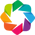

In [206]:
import requests
import sqlite3
import time
import datetime as dt
import pandas as pd
import numpy as np
import holoviews as hv
import matplotlib.pyplot as plt
hv.extension('bokeh')

## 1. Classe que gerencia dados de criptomoedas

In [209]:
# Criando a classe gerenciador_GDAX
class Gerenciador_GDAX:
    """
    Esta classe permite ao usuário gerenciar dados de cripto moedas provenientes da API da excange GADX.
    Atributos desta classe: '.produtos', e '.granularidade_BancoDeDados'
    Métodos da classe: '.capturador_OHLCV', '.consulta_BancoDeDados', '.amostra_BancoDeDados', '.limpa_BancoDeDados'
    """

    def __init__(self):
        """""
        No momento que esta classe for executada serão criados os bancos de dados 'BTC-USD.db' e 'ETH-USD.db', caso estes não existam.
        """""
        for produto in ['BTC-USD', 'ETH-USD']:    
        
            conn = sqlite3.connect(produto + ".db")
            cursor = conn.cursor()
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

            if produto not in np.array(cursor.fetchall()):
                cursor.execute("CREATE TABLE " + "'" + produto + "'" + 
                               " (id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,\
                               data TEXT,\
                               hora TEXT,\
                               abertura REAL,\
                               maximo REAL,\
                               minimo REAL,\
                               fechamento REAL,\
                               volume REAL);")         
                cursor.close()
        self.produtos = ['BTC-USD', 'ETH-USD']
        self.granularidade_BancoDeDados = '5 minutos'
    
    # Método que captura os dados da api da GDAX 
    def capturador_OHLCV(self, inicio, fim, produto):
        """
        Este método realiza a captura dos dados(OHLCV) na API da exchage GDAX('https://api.gdax.com'), 
        e os armazena em um banco de dados.
    
        Descrição dos inputs:   
        'inicio' e 'fim': Range de datas para os quais os dados serão selecionados. Estes inputs devem seguir o formato 
        'ANO-MÊS-DIA', example: '2016-02-04'.

        'produto': Trata-se do moeda ao qual as informações capturadas na API dizem respeito.
        Deve ser 'BTC-USD', ou 'ETH-USD'.
        
        Todos os inputs devem ser strings.
        
        A frequencia(granularidade) dos dados capturados é de 5 minutos.
        """

        conn = sqlite3.connect(produto + ".db")
        cursor = conn.cursor()
        cursor.execute('SELECT data FROM ' + '"' + produto + '"' + ';')
        datas = np.array(cursor.fetchall())
    
        if inicio in datas:
        
            print("Os dados para o intervalo de datas selecionado(ou para parte deste) já estão salvos no banco de dados: " + produto + ".db!")
            cursor.close()

        else:
    
            time.sleep(2)
        
            # Mensagem para usuario
            print('Realizando requests do produto {}, para o periodo de {} à {}.'.format(produto, inicio, fim))
    
            time.sleep(2)

            # Editando o input
            inicio = dt.datetime(int(inicio[0:4]),int(inicio[5:7]),int(inicio[8:10]), 2, 0, 0)
            fim = dt.datetime(int(fim[0:4]),int(fim[5:7]),int(fim[8:10])+1, 2, 0, 0)

            # Mensagem para usuario
            print('Tempo estimado de execução: {} minutos.'.format(round(((fim-inicio).days*2)/60, 2)))

            time.sleep(2)    

            # Range de periodos para fazer requests
            # Estes são criados para que as requests respeitem os limites de requesição da api
            aux = list(pd.date_range(inicio, fim, freq = '24H'))
            range_datas = [str(aux[i]) for i in range(len(aux))]

            #aux = pd.date_range(inicio, fim, freq = '24H')
            #if fim not in aux:
            #    range_datas = [str(aux[i]) for i in range(len(aux))]
            #    range_datas.append(str(fim + dt.timedelta(minutes = 1)))
            #    range_datas.append(str(fim))
            #else:
            #    range_datas = [str(aux[i]) for i in range(len(aux))]
            #    range_datas[-1] = str(aux[-1] + dt.timedelta(minutes = 1))

            # Api base da exchange
            api_base = 'https://api.gdax.com'
    
            # recebe os dados
            # output = pd.DataFrame()
    
            # Varre a lista range de datas e faz o request de dados para cada range
            for i in range(len(range_datas)-1):
        
                parametros = {}    
                parametros['start'] = range_datas[i]
                parametros['end'] = range_datas[i+1]
                parametros['granularity'] = '300'
    
                resposta = requests.get(api_base + '/products/'+produto+'/candles', params = parametros)
            
                # Caso o request tenha sido bem sucedido, então edite os dados e armazene no banco de dados
                if resposta.status_code == 200:
        
                    df = pd.DataFrame(resposta.json())
                
                    # Transforma o timestamp em formato data convencional
                    df.iloc[:,0] = [dt.datetime.fromtimestamp(datas).strftime('%Y-%m-%d %H:%M:%S') for datas in df.iloc[:,0]]
                
                    # Reordena os dados
                    df.sort_values(0, inplace = True)
                
                    # Separa a data e a hora 
                    df = pd.concat([pd.DataFrame([data.split(" ") for data in df.iloc[:,0]]), df.iloc[:,1:]], axis = 1)
                
                    # Aloca os dados em um banco de dados
                    df = np.array(df)
                    cursor.executemany("INSERT INTO " + "'" + produto +  "'" + "(data, hora, abertura, maximo, minimo, fechamento, volume) VALUES (?,?,?,?,?,?,?);", df)
                
                    # Salva os dados
                    conn.commit()
            
                # Caso o request não tenha sido bem sucedido, então aguarde 20 seguando para que o request seja refeito
                else:
            
                    print('Erro durante request... O request para o periodo de "{}" à "{}" será executando novamente.'.format(parametros['start'], parametros['end']))
            
                    time.sleep(20)
            
                    df = pd.DataFrame(response.json())

                    # Transforma o timestamp em formato data convencional            
                    df.iloc[:,0] = [dt.datetime.fromtimestamp(datas).strftime('%Y-%m-%d %H:%M:%S') for datas in df.iloc[:,0]]
              
                    # Reordena os dados
                    df.sort_values(0, inplace = True)

                    # Separa a data e a hora
                    df = pd.concat([pd.DataFrame([data.split(" ") for data in df.iloc[:,0]]), df.iloc[:,1:]], axis = 1)

                    # Aloca os dados em um banco de dados                        
                    df = np.array(df)
                    cursor.executemany("INSERT INTO " + "'" + produto +  "'" + "(data, hora, abertura, maximo, minimo, fechamento, volume) VALUES (?,?,?,?,?,?,?);", df)        

                    # Salva os dados            
                    conn.commit()

                time.sleep(0.75)
        
            conn.close()
        
            time.sleep(2)

            # Mensagem para usuario    
            print('Código executado!')
    
            time.sleep(2)

            # Mensagem para usuario
            print('Dados baixados e armazenados no banco ' + produto + '.db.')
    
    def amostra_BancoDeDados(self,inicio, fim, produto):
        """
        Este método faz consulta ao banco de dados referente ao produto especificado no input
        e retorna um data frame com dados para periodo selecionado.
        
        Descrição dos inputs:   
        'inicio' e 'fim': Range de datas para os quais os dados serão selecionados. Estes inputs devem seguir o formato 
        'ANO-MÊS-DIA', example: '2016-02-04'.

        'produto': Trata-se do moeda ao qual as informações capturadas na API dizem respeito.
        Deve ser 'BTC-USD', ou 'ETH-USD'.
        
        Todos os inputs devem ser strings.
        
        A frequencia(granularidade) dos dados capturados é de 5 minutos.

        """
        conn = sqlite3.connect(produto + ".db")
        cursor = conn.cursor()
        cursor.execute('SELECT data FROM ' + '"' + produto + '"' + ';')
        datas = np.array(cursor.fetchall())
    
        if inicio not in datas or fim not in datas:
        
            print("Para o intervalo de datas selecionados, não há dados no banco de dados.")
            time.sleep(1)
            print("Utilize o método 'consulta_BancoDeDados' para verificar para quais datas há dados no banco de dados.")

        else:
            
            cursor.execute('SELECT data, hora, abertura, maximo, minimo, fechamento, volume FROM ' + '"' + produto + '"' + ' WHERE data BETWEEN ' + '"' + inicio + '"' + ' AND ' + '"' + fim + '"' + ';')
            df = pd.DataFrame(cursor.fetchall(), columns = ['data', 'hora', 'abertura', 'maximo', 'minimo', 'fechamento', 'volume'])
            
            return(df)

        conn.close()

    # Consulta o banco de dados, e informapara quais datas há dados, se existirem
    def consulta_BancoDeDados(self, produto):
        """
        Este método faz um consulta ao banco de dados e retorna ao usuário o range de datas para o qual há dados no banco de dados.
    
        'produto': Trata-se do moeda ao qual as informações capturadas na API dizem respeito.
        Deve ser 'BTC-USD', ou 'ETH-USD'.
        
        Os inputs devem ser strings.
        """
        conn = sqlite3.connect(produto + ".db")
        cursor = conn.cursor()
        cursor.execute('SELECT data FROM ' + '"' + produto + '"' + ';')
        datas = np.array(cursor.fetchall())

        if len(datas) == 0:
            
            output = "Não há dados no banco de dados " + produto + ".db."
            
        else:
            
            output = "No banco de dados " + produto + ".db, há dados para o período de {} à {}.".format(min(datas)[0], max(datas)[0])
        
        conn.close()
        
        return(output)
    
    def limpa_BancoDeDados(self, inicio, fim, produto):
        """
        Este método elemina do banco de dados, referente ao produto especificado no input, os dados referentes
        ao periodo selecionado
        
        Descrição dos inputs:   
        'inicio' e 'fim': Range de datas para os quais os dados serão selecionados. Estes inputs devem seguir o formato 
        'ANO-MÊS-DIA', example: '2016-02-04'.

        'produto': Trata-se do moeda ao qual as informações capturadas na API dizem respeito.
        Deve ser 'BTC-USD', ou 'ETH-USD'.
        
        Todos os inputs devem ser strings.
        """
        conn = sqlite3.connect(produto + ".db")
        cursor = conn.cursor()
        cursor.execute('SELECT data FROM ' + '"' + produto + '"' + ';')
        datas = np.array(cursor.fetchall())

        if len(datas) == 0:
            
            output = "Não há dados no banco de dados " + produto + ".db para o período especificado."
            
        else:
            
            cursor.execute('DELETE FROM ' + '"' + produto + '"' + ' WHERE data >= ' + '"' + inicio + '"' + ' AND ' + 'data <= ' + '"' + fim + '"' + ';')
            output = "Os dados para o período de {} à {} foram deletados do banco de dados ".format(inicio, fim) + produto + ".db."
            conn.commit()
            
        conn.close()
        
        return(output)

    

## 2. Exemplos e descrições dos atributos e métodos da classe

##### Chamando a classe 'Gerenciador_GDAX'.
##### Ao executar o comando abaixo dois bancos de dados serão criador: 'BTC-USD' e 'ETH-USD'. Estes bancos irão receber os dados baixados pelo usuário.

In [210]:
gdax = Gerenciador_GDAX()

##### Atributo que informa os produtos que podem ser explorados com esta classe.

In [211]:
gdax.produtos

['BTC-USD', 'ETH-USD']

##### Atributo que informa a granularidadedos dados que são capturados e armazenados no banco de dados.

In [212]:
gdax.granularidade_BancoDeDados

'5 minutos'

###### Método que faz a captura de dados na API da GDAX para um determinado periodo de tempo e um determinado preoduto, e armazena os mesmos em um banco de dados.
##### O tempo estimado para baixar os dados de 2017-01-01 à 2018-01-30, para cada um dos produtos, é de  aproximadamente 13 minutos.

In [185]:
# Baixando dados para o produto 'BTC-USD'
gdax.capturador_OHLCV(inicio = '2017-01-01', fim = '2018-01-30', produto = 'BTC-USD')

In [186]:
# Baixando dados para o produto 'ETH-USD'
gdax.capturador_OHLCV(inicio = '2017-01-01', fim = '2018-01-30', produto = 'ETH-USD')

##### Método que informa ao usuário o range de datas para o qual há dados no banco de dados do referido produto.

In [217]:
gdax.consulta_BancoDeDados(produto = 'ETH-USD')

'No banco de dados ETH-USD.db, há dados para o período de 2017-01-01 à 2018-01-30.'

##### Método que retorna um data frame com dados para o referido período e produto especificados no input.

In [189]:
amostra = gdax.amostra_BancoDeDados(inicio = '2017-01-01', fim = '2018-01-30', produto = 'BTC-USD')
print(amostra.shape)
print(amostra.head(5))
print(amostra.tail(5))

(113424, 7)
         data      hora  abertura  maximo  minimo  fechamento     volume
0  2017-01-01  00:00:00    997.59  997.71  997.59      997.71  12.121186
1  2017-01-01  00:05:00    997.50  997.68  997.51      997.63   4.511970
2  2017-01-01  00:10:00    995.87  997.51  995.87      997.50   0.882310
3  2017-01-01  00:15:00    995.10  995.25  995.25      995.14   2.188443
4  2017-01-01  00:20:00    991.33  994.10  991.33      994.10   6.591334
              data      hora  abertura    maximo    minimo  fechamento  \
113419  2018-01-30  23:35:00   10915.2  10957.23  10915.20    10957.23   
113420  2018-01-30  23:40:00   10910.0  10931.18  10930.27    10915.00   
113421  2018-01-30  23:45:00   10912.9  10968.30  10940.00    10930.23   
113422  2018-01-30  23:50:00   10900.0  10942.37  10913.17    10940.00   
113423  2018-01-30  23:55:00   10900.0  10934.06  10900.01    10913.16   

           volume  
113419  11.486707  
113420  27.287799  
113421  17.400071  
113422  27.151896  
11342

###### Método que elimina dados do banco de dados para um determinado período e produto especificados no input.

In [95]:
gdax.limpa_BancoDeDados(inicio = '2017-01-01', fim = '2017-06-01', produto = 'ETH-USD')

'Não há dados no banco de dados ETH-USD.db para o período especificado.'

##### Outras informações sobre os métodos desta classe podem ser obtidas pelo comando:

In [218]:
??gdax.capturador_OHLCV

## 3. Visualizações
##### OBS: Para fazer as visualizações escolhi um conjunto de dados que vão de 2017-12-25 à 2018-01-30, pois para um conjunto de datas maior os gráficos nao estavam sendo plotados no meu computador.

In [213]:
# Dados referentes a 'ETH-USD' no perido de '2017-12-25' à '2018-01-30'.
Amostra = gdax.amostra_BancoDeDados(inicio = '2017-12-25', fim = '2018-01-30', produto = 'ETH-USD')
volume_ETH = Amostra.volume
maximo_ETH = Amostra.maximo
minimo_ETH = Amostra.minimo
abertura_ETH = Amostra.abertura
fechamento_ETH = Amostra.fechamento
media_ETH = (maximo_ETH + minimo_ETH)/2
retorno_ETH = fechamento_ETH/fechamento_ETH.shift(1) - 1
#Amostra.shape[0]

In [214]:
# Dados referentes a 'BTC-USD' no perido de '2017-12-25' à '2018-01-30'.
Amostra = gdax.amostra_BancoDeDados(inicio = '2017-12-25', fim = '2018-01-30', produto = 'BTC-USD')
volume_BTC = Amostra.volume
maximo_BTC = Amostra.maximo
minimo_BTC = Amostra.minimo
abertura_BTC = Amostra.abertura
fechamento_BTC = Amostra.fechamento
media_BTC = (maximo_BTC + minimo_BTC)/2
retorno_BTC = fechamento_BTC/fechamento_BTC.shift(1) - 1
#Amostra.shape[0]

#### 3.1 Comparando o preço médio com os preços de abertura, fechamento, máximo e mínimo.
##### a) ETH-USD

In [196]:
def carrega_dado(symbol, **kwargs):
    df = dados[symbol]
    return hv.Curve(df, 'Tempo(2017-12-25 à 2018-01-30)', 'Preço') * hv.Scatter(media_ETH).relabel('Preço médio')

informacao = ['Preço maximo', 'Preço minimo', 'Preço abertura', 'Preço fechamento']
dados = {'Preço maximo':maximo_ETH, 'Preço minimo':minimo_ETH, 'Preço abertura':abertura_ETH, 'Preço fechamento':fechamento_ETH}
comparacao = hv.DynamicMap(carrega_dado, kdims='ETH').redim.values(ETH=informacao)

In [197]:
%%opts Scatter [width=700] (color='blue') {+framewise}
%%opts Curve [width=700] (color='red') {+framewise}
comparacao

:DynamicMap   [ETH]

##### b) BTC-USD

In [198]:
def carrega_dado(symbol, **kwargs):
    df = dados[symbol]
    return hv.Curve(df, 'Tempo(2017-12-25 à 2018-01-30)', 'Preço') * hv.Scatter(media_BTC).relabel('Preço médio')

informacao = ['Preço maximo', 'Preço minimo', 'Preço abertura', 'Preço fechamento']
dados = {'Preço maximo':maximo_BTC, 'Preço minimo':minimo_BTC, 'Preço abertura':abertura_BTC, 'Preço fechamento':fechamento_BTC}
comparacao = hv.DynamicMap(carrega_dado, kdims='BTC').redim.values(BTC=informacao)

In [199]:
%%opts Scatter [width=700] (color='blue') {+framewise}
%%opts Curve [width=700] (color='red') {+framewise}
comparacao

:DynamicMap   [BTC]

#### 3.2 Scatterplot: Volume contra Retorno 
#### Tentativa de checar a existencia de algum tipo de correlação entre o retorno e o volume

##### a) ETH-USD 

In [200]:
%%output size=150 
points = hv.Points(np.transpose(np.array([volume_ETH, retorno_ETH])))
points.hist(num_bins=100, dimension=['x','y']).relabel('ETH: Volume(x), Retorno(y)')

:AdjointLayout
   :Points   [x,y]
   :Histogram   [y]   (y_frequency)
   :Histogram   [x]   (x_frequency)

##### b) BTC-USD

In [201]:
%%output size=150 
points = hv.Points(np.transpose(np.array([volume_BTC, retorno_BTC])))
points.hist(num_bins=100, dimension=['x','y']).relabel('BTC: Volume(x), Retorno(y)')

:AdjointLayout
   :Points   [x,y]
   :Histogram   [y]   (y_frequency)
   :Histogram   [x]   (x_frequency)

#### 3.3 Curva do Preço médio e Barplot do volume
##### a) ETH-USD

In [202]:
%%opts Curve [width=900] (color='orange') {+framewise}
(hv.Bars(volume_ETH, 'Período(2017-12-25 à 2018-01-30)', 'Preço/Volume').relabel('Volume') * hv.Curve(media_ETH).relabel('Preço médio')).relabel('ETH-USD')

:Overlay
   .Bars.Volume       :Bars   [Período(2017-12-25 à 2018-01-30)]   (Preço/Volume)
   .Curve.Preço_médio :Curve   [x]   (y)

##### b) BTC-USD
##### OBS: Para este produto, o volume é muito baixo, por isso não fica visualizavel no gráfico

In [203]:
%%opts Curve [width=900] (color='orange') {+framewise}
(hv.Bars(volume_BTC, 'Período(2017-12-25 à 2018-01-30)', 'Preço/Volume').relabel('Volume') * hv.Curve(media_BTC).relabel('Preço médio')).relabel('BTC-USD')

:Overlay
   .Bars.Volume       :Bars   [Período(2017-12-25 à 2018-01-30)]   (Preço/Volume)
   .Curve.Preço_médio :Curve   [x]   (y)

#### 3.4 Comparação preço médio BTC-USD e o preço médio ETH-USD

In [204]:
%%opts Scatter [width=900] (color='pink') {+framewise}
%%opts Curve [width=900] (color='black') {+framewise}
(hv.Scatter(media_BTC, 'Período(2017-12-25 à 2018-01-30)', 'Preço').relabel('BTC') * hv.Curve(media_ETH).relabel('ETH')).relabel('Comparação: Preço médio BTC X Preço médio ETH')


:Overlay
   .Scatter.BTC :Scatter   [Período(2017-12-25 à 2018-01-30)]   (Preço)
   .Curve.ETH   :Curve   [x]   (y)

#### 3.5 Retorno do BTC-USD e do ETH-USD para o período de 2017-12-25 à 2018-01-30

In [205]:
%%opts Curve [width=400, height=400, show_grid=True] {+framewise} 
hv.Curve(retorno_BTC, 'Período(2017-12-25 à 2018-01-30)', 'Retorno(%)', label='Retorno BTC-USD').hist(num_bins=150) + hv.Curve(retorno_ETH, 'Período(2017-12-25 à 2018-01-30)', 'Retorno(%)', label='Retorno ETH-USD').hist(num_bins=150)

:Layout
   .AdjointLayout.Retorno_BTC_hyphen_minus_USD :AdjointLayout
      :Curve   [Período(2017-12-25 à 2018-01-30)]   (Retorno(%))
      :Histogram   [Retorno(%)]   (Retorno(%)_frequency)
   .AdjointLayout.Retorno_ETH_hyphen_minus_USD :AdjointLayout
      :Curve   [Período(2017-12-25 à 2018-01-30)]   (Retorno(%))
      :Histogram   [Retorno(%)]   (Retorno(%)_frequency)